In [ ]:
#| default_exp preprocess

In [ ]:
#| hide
from nbdev.showdoc import *

# preprocess
> This module will contain the functions used to preprocess the data to be used in the training process and it will contain the preprocessing done to successfully batch data

In [ ]:
#| export
from pathlib import Path
import librosa
from numpy import array
import torch
import numpy as np

In [ ]:
#| hide
from fastspeech.loading import *
from fastcore.foundation import L
from functools import partial
from fastspeech.visualize import show_mels, show_mel
from fastspeech.loading import melspectrogram
from torch import tensor

In [ ]:
#| hide
path = Path("../sample_data/")
sr = 22050
hl = 256
cut = 10

file_paths = get_audio_files(path)
tgt_paths = L(file_paths).map(partial(replace_extension, extension='.TextGrid'))
vocab_path = Path("../sample_data/cmudict-0.7b.symbols.txt")

wavs = list(map(partial(load_audio, sr=22050), file_paths[:cut]))
phones, durations = zip(*map(partial(get_phones_and_durations, sr=sr, hl=hl), 
                             tgt_paths[:cut]))

wav = wavs[0]

## phones

In [ ]:
#| export
class Vocab:
    '''This is a vocab object to used to load in a vocabulary, vectorize phonemes, and decode embeddings'''
    def __init__(self, 
                 vocab_path: str, # The path to vocabulary file containing all the words in the vocabulary
                 specials: list =[]): # The special tokens not in the vocabulary file
        pad_token = "<pad>"
        self.vocab = self._load_vocab(vocab_path) + [pad_token] + specials
        self.tok2idx = {tok: i for i, tok in enumerate(self.vocab)}
        self.pad_num = self.tok2idx[pad_token]
    
    def __getitem__(self, val): # The token string or the vectorized integer
        val_type = type(val)
        if val_type == int and val < len(self.vocab): 
            return self.vocab[val]
        elif val_type == str:
            return self.tok2idx[val]
        else:
            raise Exception(f"Used the wrong type: {val_type}")
        
    def __len__(self):
        return len(self.vocab)
        
    def _load_vocab(self, vocab_path: str): # The path to the phoneme vocab list
        lines = Path(vocab_path).open().readlines()
        return list(map(lambda x: x.strip(), lines))

In [ ]:
vocab = Vocab(vocab_path, ['spn'])
vocab[10], vocab[vocab[10]], len(vocab)

('AH1', 10, 86)

## audio

In [ ]:
#| hide
mels = list(map(melspectrogram, wavs))
mel = mels[0]

In [ ]:
#| export
def trim_audio(inp: array, # Input audio array
               top_db: int, # The threshold (in decibels) below reference to consider as silence
               n_fft: int, # The number of samples per analysis frame
               hl: int): # The number of samples between analysis frames
    audio, _  = librosa.effects.trim(y=inp, top_db=top_db, frame_length=n_fft, hop_length=hl)
    return audio

In [ ]:
trimmed = trim_audio(wav, top_db=30, n_fft=1024, hl=256)
len(wav) - len(trimmed)

2205

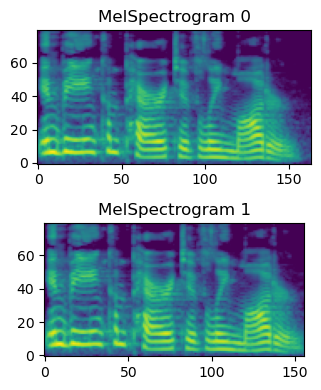

In [ ]:
trimmed_mel = melspectrogram(trimmed)
show_mels([mel, trimmed_mel]);

In [ ]:
#| hide
from IPython.display import Audio, display

In [ ]:
display(Audio(wav, rate=sr))
display(Audio(trimmed, rate=sr))

## durations

In [ ]:
#| hide
duration = tensor(durations[0])
mel_len = mel.shape[-1]

In [ ]:
#| export
def round_and_align_durations(duration, mel_len):
    '''Rounds duration such that durations add up to the mel length and if 
    they don\'t add up it adds to each phoneme based on difference between 
    rounded and duration'''
    rounded_duration = duration.round()
    total_duration = rounded_duration.sum().int().item()
    
    if total_duration != mel_len:
        unit = -1 if total_duration > mel_len else 1
        
        descending = True if unit == 1 else False
        sorted_idxs = torch.argsort((rounded_duration-duration), descending=descending)
        n = len(sorted_idxs)
        
        difference = int(abs(total_duration - mel_len))
        for i in range(difference):
            idx = sorted_idxs[i % n]
            rounded_duration[idx] += unit
            
    return rounded_duration

In [ ]:
rounded = round_and_align_durations(duration, mel_len)
rounded

tensor([ 6.,  6.,  3.,  7., 10.,  4.,  7.,  4.,  5., 10.,  4.,  9.,  4.,  9.,
         5.,  6., 10.,  5., 10., 15.,  4., 10., 11.])

## regularization

In [ ]:
#| export
def flatten_and_concat(arrays: list[array]):
    concatenated_arrays = np.concatenate([a.flatten() for a in arrays])
    return concatenated_arrays

In [ ]:
flattened = flatten_and_concat(mels)
flattened.shape

(79680,)

In [ ]:
#| export
class ZScoreNormalization:
    def __init__(self, mean: float, std: float):
        '''Creates a normalization object that allows for normalization and 
        denormalization'''
        self.mean, self.std = mean, std
        
    def normalize(self, inp: tensor):
        return (inp - mean) / std
    
    def denormalize(self, inp: tensor):
        return inp * std + mean

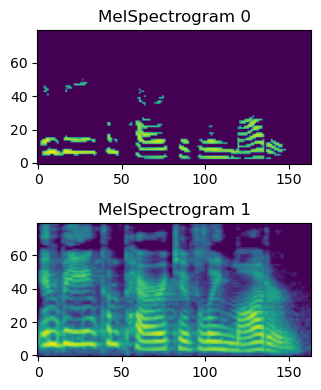

In [ ]:
mean, std = flattened.mean(), flattened.std()
norm = ZScoreNormalization(mean, std)

normalized_mel = norm.normalize(mel)
denormalized_mel = norm.denormalize(normalized_mel)

show_mels([normalized_mel, denormalized_mel])

In [ ]:
#| export
class MinMaxNormalization:
    def __init__(self, max_val: float, min_val: float):
        '''Creates a normalization object that allows for normalization and 
        denormalization'''
        self.max_val, self.min_val = max_val, min_val
    
    def normalize(self, inp):
        return (inp - self.min_val) / (self.max_val - self.min_val)
    
    def denormalize(self, inp):
        return inp * (self.max_val - self.min_val) + self.min_val

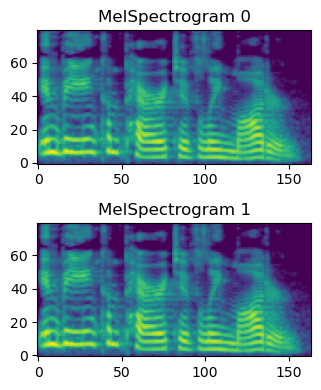

In [ ]:
max_val, min_val = flattened.max(), flattened.min()
norm = MinMaxNormalization(max_val, min_val)

normalized_mel = norm.normalize(mel)
denormalized_mel = norm.denormalize(normalized_mel)

show_mels([normalized_mel, denormalized_mel])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()